In [63]:
import re 
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from simhash import Simhash
import matplotlib.pyplot as plt

def seed_everything(seed: int):
    import random, os
    import numpy as np
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

# 核心算法

In [64]:
# MSKTS文本相似度比對算法
url = 'https://gist.githubusercontent.com/skywalker0803r/7c00d680d731b99ab549dd40a96006ce/raw/d9bb060a42285053faa5227df521b43f381f1a0b/MSKTS.py'
exec(requests.get(url).text)

# help function

In [65]:
# 只保留英文字母
def keep_alpha(str1): 
  char = "" 
  for x in str(str1):
    if x.isalpha(): 
      char = "".join([char, x])
  return char

# 基於規則之關鍵字匹配算法
def matching(sentence,database):
  candidate_list = []
  for word in database:
    if word in sentence: 
      candidate_list.append(word)
  return candidate_list

# string_list中的string若為其他string的"子集"則剔除
def substringSieve(string_list):
    string_list.sort(key=lambda s: len(s), reverse=True)
    out = []
    for s in string_list:
      if not any([s in o for o in out]):
        out.append(s)
    return out

# 去除多重空白
def remove_multiple_blanks(x):
  for i in range(2,10,1):
    x = x.replace(' '*i,' ')
  return x

# 輸入sentence前處理
def preprocess_raw_sentence(x):
  x = str(x).upper() # 轉大寫字串
  x = re.sub('[\u4e00-\u9fa5]', '', x) # 去除中文
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.replace('\n', '').replace('\r', '').replace('\t', '') # 去除換行符號
  str.strip(x) # 移除左右空白
  x = remove_multiple_blanks(x) # 去除多重空白
  x = ' ' + x + ' '# 出現在頭的 就不可能對到前後加空格的 這種情形要想想怎麼對照(加上左右空白)
  return x

# 字串長度小於3的單詞前後加空白
def add_space(x):
    if (' ' not in x) and (len(x)<=3): 
        return ' ' + x + ' '
    else:
        return x

# 產品後處理
def product_name_postprocess(x):
  x = str(x).upper() # 轉大寫字串
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.strip() # 去除空白
  x = add_space(x)# 字串長度小於3的單詞前後加空白
  return x

# 基於關鍵字比對方法的預測函數
def predict_keyword(title,test_df,Unrecognized,input_col,database,output_col):
  result = []
  for i in tqdm(test_df.index):
    candidate_list = matching(
        sentence = test_df.loc[i,input_col],
        database = set(database) - set(Unrecognized)
        )
    result.append(substringSieve(candidate_list))
  test_df[output_col] = result
  return test_df

# 取得dataframe的空列表索引
def get_empty_list_idx(df,col):
  error_idx = []
  for idx,name in enumerate(df[col].values.tolist()):
    if len(name) == 0:
      error_idx.append(idx)
  return error_idx
  

# 載入數據


In [66]:
# 歷史資料庫
database = pd.read_excel('../data/combined_excel.xlsx')
# 新的測試數據
test_data = pd.read_csv('../data/測試數據/0927到2022.csv')

# 讀取"產品名"寶典
品名寶典 = pd.read_excel('../data/寶典/寶典人工處理後/寶典.v9.202111202.xlsx',engine='openpyxl')[['CODIV','DIVNM','ITEMNM']]
品名寶典 = 品名寶典.rename(columns={'ITEMNM':'品名','DIVNM':'公司事業部門','CODIV':'公司代號'})
品名寶典['品名'] = 品名寶典['品名'].apply(lambda x:product_name_postprocess(x))

# 讀取"開狀人"寶典
開狀人寶典 = pd.read_csv('../data/寶典/開狀人寶典.csv')

# 讀取"公司"寶典
公司寶典 = pd.read_csv('../data/寶典/公司寶典加尾綴.csv')

In [67]:
小公司列表 = []
for i in 公司寶典['代號']:
    if (len(i) == 2) and (i[0].isalpha()) and (i[1].isalpha()):
        小公司列表.append(i)
小公司列表

['AF',
 'AH',
 'AL',
 'BM',
 'BN',
 'GF',
 'IF',
 'RS',
 'RW',
 'RZ',
 'XU',
 'XZ',
 'BQ',
 'RC',
 'RP',
 'RA',
 'RV',
 'TN',
 'TR',
 'BW']

# 按照時間排序資料

In [68]:
def sort_by_form(df):
    df = df.sort_values(by='from')
    df = df.reset_index(drop=True)
    return df
database = sort_by_form(database)
test_data = sort_by_form(test_data)

# 定義欄位

In [69]:
產品名輸入 = '45A' #產品名
開狀人輸入 = '50' #開狀人
受益人輸入 = '59' #受益人
開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
輸出欄位 = ['產品名','開狀人','受益人','開狀銀行']
輸入欄位 = ['45A','50','59','LTADDRESS.1']

# 預處理函數

In [70]:
# 針對模型輸入做預處理
def 預處理(df):
  產品名輸入 = '45A' #產品名
  開狀人輸入 = '50' #開狀人
  受益人輸入 = '59' #受益人
  開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
  for i in [產品名輸入,開狀人輸入,受益人輸入]:
    df[i] = df[i].apply(lambda x:preprocess_raw_sentence(x))
  return df

# 抽特徵函數

In [71]:
def 抽特徵(df,品名寶典=None,開狀人寶典=None,公司寶典=None):
  # 預測產品
  df = predict_keyword(
      title = '正在預測產品',
      test_df = df,
      Unrecognized = ['PE','MA','EA','GRADE','INA','PACK','PP','PA','']+[' '*i for i in range(1,10,1)],
      input_col = 產品名輸入,
      database = list(map(lambda x:str(x).upper(),品名寶典['品名'].values.tolist())),
      output_col = '產品名',
      )

  # 預測開狀人
  df = predict_keyword(
      title = '正在預測開狀人',
      test_df = df,
      Unrecognized = ['']+[' '*i for i in range(1,10,1)],
      input_col = 開狀人輸入,
      database = list(map(lambda x:str(x).upper(),開狀人寶典['開狀人'].values.tolist())),
      output_col = '開狀人',
      )

  # 預測公司(受益人)
  df = predict_keyword(
      title = '正在預測受益人',
      test_df = df,
      Unrecognized = ['']+[' '*i for i in range(1,10,1)],
      input_col = 受益人輸入,
      database = list(map(lambda x:str(x).upper(),公司寶典['公司英文名稱'].values.tolist())),
      output_col = '受益人',
      )

  # 預測開狀銀行
  df['開狀銀行'] = df[開狀銀行輸入].apply(lambda x:str(x)[:8])
  return df

# 準備訓練資料

In [72]:
database = 抽特徵(預處理(database),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=database,col=i)
    print(i,'空列表數量:',len(number))
database[輸出欄位].tail(5)

<ipython-input-65-4e4c7646e576>:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(test_df.index):



產品名 空列表數量: 7397
開狀人 空列表數量: 7081
受益人 空列表數量: 6885
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
20732,[NYLON 6 FILAMENT YARN],[SKY INDUSTRIES LTD],[FORMOSA CHEMICALS AND FIBRE],KKBKINBB
20733,[PVC SUSPENSION RESIN],[L D INTERNATIONAL],[FORMOSA PLASTICS],KKBKINBB
20734,"[EPOXY RESIN, NPEF]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20735,"[EPOXY RESIN, NPEL]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20736,[PVC RESIN],[PRAGYA FLEXIFILM INDUSTRIES],[FORMOSA PLASTICS],KKBKINBB


# 準備測試資料

In [73]:
test_data = 抽特徵(預處理(test_data),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=test_data,col=i)
    print(i,'空列表數量:',len(number))
test_data[輸出欄位].tail(5)

<ipython-input-65-4e4c7646e576>:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(test_df.index):



產品名 空列表數量: 176
開狀人 空列表數量: 571
受益人 空列表數量: 73
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP
2424,[RESIN],[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT
2426,[PVC COPOLYMER RESIN],[S R POLYVINYL LIMITED],[FORMOSA PLASTICS],INDBINBB


# 模型測試

In [74]:
def 根據特定欄位和索引給出候選答案清單(col,idx,k,database_size=100,database=None,test_data=None):
  # 判斷是否為空列表
  if len(test_data[col][idx]) == 0:
    return []
  # 預處理
  database['處理過的資料'] = (database[col]).apply(keep_alpha)
  test_data['處理過的資料'] = (test_data[col]).apply(keep_alpha)
  # 建立模型
  model = MSKTS()
  model.fit(list(set(database['處理過的資料'].sample(database_size).values.tolist()) - set(['']+[' '*i for i in range(1,10,1)])))
  # 產生預測答案清單
  output = [i[0] for i in model.predict(test_data['處理過的資料'][idx],k=k)]
  預測答案清單 = database.loc[database['處理過的資料'].isin(output),'EXPNO'].dropna().apply(lambda x:str(x)[:2]).values.tolist()
  return 預測答案清單

# 測試正確率

In [75]:
def 目標函數(database_size,database,test_data,test_n=20):
  # 根據四項欄位做預測
  test_data['預測EXPNO'] = None
  correct = []
  for idx in tqdm(range(test_n)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o = o1+o3
    # 判斷是否為小公司
    if len(set(o)&set(小公司列表)) > 0:
      o = list(set(o)&set(小公司列表))
    else:
      o = o1
    # 取眾數
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    # 指派預測值至test_data
    test_data.loc[idx,'預測EXPNO'] = ensemble_output
    # 計算正確率
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  return np.mean(correct),test_data
acc,test_data = 目標函數(database_size=len(database),database=database,test_data=test_data)
print('正確率:',acc)

<ipython-input-75-172715e99a0e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(test_n)):



正確率: 0.85


# 加入錯誤feedback寶典後再測試

In [76]:
feedback = pd.read_excel('../data\寶典\寶典人工處理後\寶典_feedback.xlsx',index_col=0)
display(feedback.head())

品名寶典_加入錯誤feedback = 品名寶典.append(feedback).reset_index(drop=True).drop_duplicates()
display(品名寶典_加入錯誤feedback)

database = 抽特徵(預處理(database),品名寶典=品名寶典_加入錯誤feedback,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=database,col=i)
    print(i,'空列表數量:',len(number))
display(database[輸出欄位].tail(5))

test_data = 抽特徵(預處理(test_data),品名寶典=品名寶典_加入錯誤feedback,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=test_data,col=i)
    print(i,'空列表數量:',len(number))
display(test_data[輸出欄位].tail(5))

acc,test_data = 目標函數(database_size=len(database),database=database,test_data=test_data)
display('正確率:',acc)

,公司代號,公司事業部門,品名
7,2E,not find,TAIRILIN BRAND POLYESTER FILM
9,25,not find,POLYESTER PET CHIP
18,4A,not find,TAIRISAN SAN RESINS
28,2P,not find,BUTANEDIOL
41,28,not find,GLASS FABRICS


,公司代號,公司事業部門,品名
0,11,塑膠事業部,COPOLYMER PVC C1250M
1,11,塑膠事業部,COPOLYMER PVC C15
2,11,塑膠事業部,COPOLYMER PVC C8
3,11,塑膠事業部,MASS PVC B57
4,11,塑膠事業部,MASS PVC B57C
...,...,...,...
1190,25,not find,polyester fiber
1191,48,not find,PTA
1193,1P,not find,PLASTIC RESIN
1196,2R,not find,TPN1


<ipython-input-65-4e4c7646e576>:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(test_df.index):



產品名 空列表數量: 7036
開狀人 空列表數量: 7081
受益人 空列表數量: 6885
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
20732,[NYLON 6 FILAMENT YARN],[SKY INDUSTRIES LTD],[FORMOSA CHEMICALS AND FIBRE],KKBKINBB
20733,[PVC SUSPENSION RESIN],[L D INTERNATIONAL],[FORMOSA PLASTICS],KKBKINBB
20734,"[EPOXY RESIN, NPEF]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20735,"[EPOXY RESIN, NPEL]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20736,[PVC RESIN],[PRAGYA FLEXIFILM INDUSTRIES],[FORMOSA PLASTICS],KKBKINBB


<ipython-input-65-4e4c7646e576>:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(test_df.index):



產品名 空列表數量: 122
開狀人 空列表數量: 571
受益人 空列表數量: 73
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP
2424,[RESIN],[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT
2426,[PVC COPOLYMER RESIN],[S R POLYVINYL LIMITED],[FORMOSA PLASTICS],INDBINBB


<ipython-input-75-172715e99a0e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(test_n)):


'正確率:'

0.85

# 觀察不同資料筆數 對正確率的影響

<ipython-input-75-172715e99a0e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(test_n)):



[10, 100, 1000, 20737] [0.3, 0.6, 0.6, 0.85]


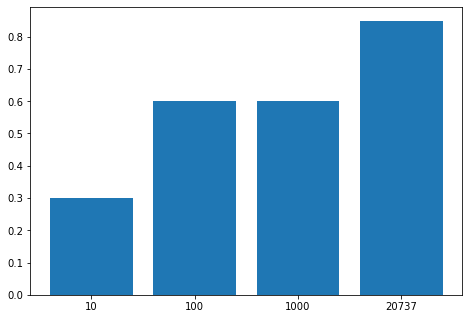

In [77]:
x = [10,100,1000,len(database)]
y = [目標函數(database_size=i,database=database,test_data=test_data)[0] for i in x]
print(x,y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([str(i) for i in x],y)
plt.show()

# 觀察不同database對正確率的影響

In [ ]:
# 載入數據
database2 = pd.read_excel('../data/combined_excel_D.xlsx')

# 欄位定義
database2col = []
for i in database2.columns:
    if 'ERP' not in i:
        database2col.append(i)

# 欄位定義
database3col = []
for i in database2.columns:
    if '電文' not in i:
        database3col.append(i)

# 切分資料
database2,database3 = database2[database2col],database2[database3col]

# 統一命名
database2 = database2.rename(
    columns={
        '產品名_電文':'45A',
        '開狀人_電文':'50',
        '受益人_電文':'59',
        '開狀銀行_電文':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database2.head())

# 統一命名
database3 = database3.rename(
    columns={
        '產品名_ERP':'45A',
        '開狀人_ERP':'50',
        '受益人_ERP':'59',
        '開狀銀行_ERP':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database3.head())

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

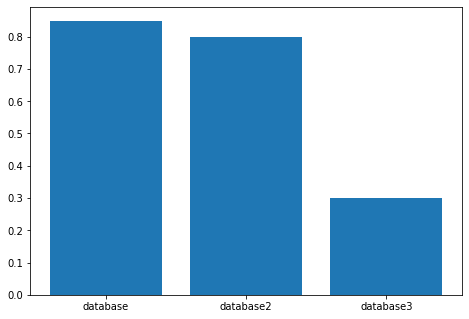

In [ ]:
x = [抽特徵(預處理(database)),抽特徵(預處理(database2)),抽特徵(預處理(database3))]
y = [目標函數(database_size=len(i),database=i,test_data=test_data,test_n=20)[0] for i in x]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['database','database2','database3'],y)
plt.show()

# 輸出預測結果

In [ ]:
acc,test_data = 目標函數(
    database_size=len(database),
    database=database,
    test_data=test_data,
    test_n=len(test_data))
print(f'正確率:{acc}')
test_data[輸出欄位+['推薦公司事業部','預測EXPNO']].head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/2427 [00:00<?, ?it/s]

正確率:0.7136382365059745


,產品名,開狀人,受益人,開狀銀行,推薦公司事業部,預測EXPNO
0,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],[FORMOSA PLASTICS],ICICINBB,11,11
1,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,2A,2A
2,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,2A,2A
3,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],[FORMOSA PLASTICS],INDBINBB,11,11
4,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],[NAN YA PLASTICS],BOTKJPJT,21,12


# save

In [ ]:
test_data[輸出欄位+['推薦公司事業部','預測EXPNO']].to_excel('../predict_result/預測結果.xlsx')